# Hudba a neurónové siete
## Bakárska práca
### Peter Oliver Kolek

In [16]:
from mido import MidiFile, MidiTrack, MetaMessage, bpm2tempo, Message
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import np_utils
import matplotlib.pyplot as plt
import keras

In [2]:
def open_midi(midi_file):
    # open midi file
    mid = MidiFile(midi_file, clip=True)

    drum_track_number = 0
    # find track number of drums
    for i in range(len(mid.tracks)):
        for j in range(len(mid.tracks[i])):
            if mid.tracks[i][j].is_meta:
                continue
            if mid.tracks[i][j].channel == 9:
                drum_track_number = i
                break
    return mid, mid.tracks[drum_track_number]

In [3]:
def get_transcription(drum_track, mid):
    # find ticks per beat, and divide it to Thirty-Second 32 notes
    ticks_per_beat_in_32_notes = mid.ticks_per_beat / 8
    print(ticks_per_beat_in_32_notes)
    # change notes time to stick it to 32 notes
    tmp_time = 0
    time_with_note = {}
    for i, message in enumerate(drum_track):
        # find time how it goes through song
        tmp_time += drum_track[i].time
        message.time = round(tmp_time / ticks_per_beat_in_32_notes)
        # make velocity of notes same
        if message.type == 'note_on':
            if message.velocity > 0:
                message.velocity = 1

    # crating DataFrame for notes sticked to 32s and filter only note_on notes
    transcription = pd.DataFrame(m.dict() for m in drum_track)
    transcription = transcription[transcription.type == 'note_on']
    # modify table to have columns for every note and lines with time (32 notes as they folow the song)
    transcription = transcription.pivot_table(index='time', columns='note', values='velocity', fill_value=0)
    # because we have 4/4 tempo, we have to add notes to have folowing 32 notes and empty values we fill with zeros
    transcription = transcription.reindex(pd.RangeIndex(transcription.index.max() + 1)).fillna(0).sort_index()
    # retype to int
    transcription = transcription.astype(int)
    transcription.columns = transcription.columns.astype(int)
    transcription = transcription.reset_index(drop=True)
    return transcription

In [56]:
def create_midi(tempo, transcription, ticks_per_beat):
    # create new midi file
    new_mid = MidiFile()
    new_mid.ticks_per_beat = ticks_per_beat
    meta_track = MidiTrack()
    new_mid.tracks.append(meta_track)

    # necessary meta track
    meta_track.append(MetaMessage(type='track_name', name='meta_track', time=0))
    meta_track.append(MetaMessage(type='time_signature', numerator=4, denominator=4, clocks_per_click=24,
                                  notated_32nd_notes_per_beat=8, time=0))
    meta_track.append(MetaMessage(type='set_tempo', tempo=bpm2tempo(tempo), time=0))

    drum_track_new = MidiTrack()
    new_mid.tracks.append(drum_track_new)

    # apend notes to drum track
    ticks_per_32note = int(ticks_per_beat/8)
    notes_from_last_message = 0
    for i, note in enumerate(transcription):
        if i == 0:
            for idx, inst in enumerate(note):
                if inst == 0:
                    continue
                drum_track_new.append(Message('note_on', channel=9, note=instruments[idx], velocity=80, time=0))
            continue
        else:
            if sum(note) < 1:
                notes_from_last_message += 1
                continue
            else:
                notes_from_last_message += 1

            same_note_count = 0
            for idx, inst in enumerate(note):
                if inst == 0:
                    pass
                # if there are more notes at the same time played, they must have time 0
                elif same_note_count == 0:
                    drum_track_new.append(Message('note_on', channel=9, note=instruments[idx], velocity=80,
                                                  time=notes_from_last_message * ticks_per_32note))
                    same_note_count += 1
                else:
                    drum_track_new.append(Message('note_on', channel=9, note=instruments[idx], velocity=80, time=0))
                    same_note_count += 1
            notes_from_last_message = 0
    new_mid.save("./output/output.mid")

In [5]:
mid, drum_track = open_midi('./RHCP_midi/FortuneFaded.mid')

In [6]:
transcription = get_transcription(drum_track, mid)
print(transcription.values)
# find all instruments in song
instruments = transcription.columns.tolist()

120.0
[[1 1 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 0 0 0]]


In [7]:
inputs_list = []
outputs_list = []
sequence_len = 32
raw_notes = transcription.values
for i in range(len(raw_notes) - sequence_len):
    input_start = i
    input_end = i + sequence_len
    output_start = input_end
    output_end = output_start + 1

    # for every 32 notes sequence set next note as output
    inputs_list.append(raw_notes[input_start:input_end])
    outputs_list.append(raw_notes[output_start:output_end])

outputs_list = list(np.array(outputs_list).reshape(-1, np.array(outputs_list).shape[-1]))

inputs_list = np.array(inputs_list)
outputs_list = np.array(outputs_list)

output_shape = outputs_list.shape[1]

In [50]:
dropout = 0.3

# very very very basic LSTM model
model = Sequential()
model.add(LSTM(sequence_len, input_shape=(sequence_len, len(instruments)), return_sequences=True, dropout=dropout))
model.add(LSTM(sequence_len, return_sequences=True, dropout=dropout))
model.add(LSTM(sequence_len, dropout=dropout))
model.add(Dense(output_shape, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',keras.metrics.BinaryCrossentropy()])

mc = ModelCheckpoint(filepath='./new_encode_1st_try.h5', monitor='val_loss', verbose=1, save_best_only=True)

history = model.fit(inputs_list, outputs_list, epochs=200, callbacks=mc, validation_split=0.1, verbose=1, shuffle=False)

Epoch 1/200
89/89 [==============================] - 10s 42ms/step - loss: 0.3825 - accuracy: 0.3501 - binary_crossentropy: 0.3825 - val_loss: 0.2897 - val_accuracy: 0.9045 - val_binary_crossentropy: 0.2897

Epoch 00001: val_loss improved from inf to 0.28975, saving model to ./new_encode_1st_try.h5
Epoch 2/200
89/89 [==============================] - 3s 28ms/step - loss: 0.2638 - accuracy: 0.7159 - binary_crossentropy: 0.2638 - val_loss: 0.2884 - val_accuracy: 0.9045 - val_binary_crossentropy: 0.2884

Epoch 00002: val_loss improved from 0.28975 to 0.28845, saving model to ./new_encode_1st_try.h5
Epoch 3/200
89/89 [==============================] - 3s 30ms/step - loss: 0.2602 - accuracy: 0.7496 - binary_crossentropy: 0.2602 - val_loss: 0.2886 - val_accuracy: 0.9045 - val_binary_crossentropy: 0.2886

Epoch 00003: val_loss did not improve from 0.28845
Epoch 4/200
89/89 [==============================] - 3s 28ms/step - loss: 0.2594 - accuracy: 0.7581 - binary_crossentropy: 0.2594 - val_los


Epoch 00029: val_loss did not improve from 0.18965
Epoch 30/200
89/89 [==============================] - 3s 37ms/step - loss: 0.1428 - accuracy: 0.5399 - binary_crossentropy: 0.1428 - val_loss: 0.1904 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.1904

Epoch 00030: val_loss did not improve from 0.18965
Epoch 31/200
89/89 [==============================] - 3s 34ms/step - loss: 0.1403 - accuracy: 0.5431 - binary_crossentropy: 0.1403 - val_loss: 0.1904 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.1904

Epoch 00031: val_loss did not improve from 0.18965
Epoch 32/200
89/89 [==============================] - 3s 37ms/step - loss: 0.1402 - accuracy: 0.5498 - binary_crossentropy: 0.1402 - val_loss: 0.1905 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.1905

Epoch 00032: val_loss did not improve from 0.18965
Epoch 33/200
89/89 [==============================] - 3s 34ms/step - loss: 0.1417 - accuracy: 0.5559 - binary_crossentropy: 0.1417 - val_loss: 0.1905 - val_accuracy: 0.500

89/89 [==============================] - 3s 31ms/step - loss: 0.1341 - accuracy: 0.7435 - binary_crossentropy: 0.1341 - val_loss: 0.1900 - val_accuracy: 0.7484 - val_binary_crossentropy: 0.1900

Epoch 00061: val_loss did not improve from 0.18952
Epoch 62/200
89/89 [==============================] - 3s 32ms/step - loss: 0.1332 - accuracy: 0.7506 - binary_crossentropy: 0.1332 - val_loss: 0.1897 - val_accuracy: 0.7484 - val_binary_crossentropy: 0.1897

Epoch 00062: val_loss did not improve from 0.18952
Epoch 63/200
89/89 [==============================] - 3s 32ms/step - loss: 0.1328 - accuracy: 0.7613 - binary_crossentropy: 0.1328 - val_loss: 0.1894 - val_accuracy: 0.7484 - val_binary_crossentropy: 0.1894

Epoch 00063: val_loss improved from 0.18952 to 0.18941, saving model to ./new_encode_1st_try.h5
Epoch 64/200
89/89 [==============================] - 3s 30ms/step - loss: 0.1328 - accuracy: 0.7620 - binary_crossentropy: 0.1328 - val_loss: 0.1895 - val_accuracy: 0.7484 - val_binary_cross


Epoch 00089: val_loss improved from 0.15721 to 0.14926, saving model to ./new_encode_1st_try.h5
Epoch 90/200
89/89 [==============================] - 3s 31ms/step - loss: 0.1131 - accuracy: 0.6744 - binary_crossentropy: 0.1131 - val_loss: 0.1455 - val_accuracy: 0.6529 - val_binary_crossentropy: 0.1455

Epoch 00090: val_loss improved from 0.14926 to 0.14552, saving model to ./new_encode_1st_try.h5
Epoch 91/200
89/89 [==============================] - 3s 30ms/step - loss: 0.1070 - accuracy: 0.6942 - binary_crossentropy: 0.1070 - val_loss: 0.1319 - val_accuracy: 0.6178 - val_binary_crossentropy: 0.1319

Epoch 00091: val_loss improved from 0.14552 to 0.13185, saving model to ./new_encode_1st_try.h5
Epoch 92/200
89/89 [==============================] - 3s 30ms/step - loss: 0.1021 - accuracy: 0.6935 - binary_crossentropy: 0.1021 - val_loss: 0.1206 - val_accuracy: 0.4013 - val_binary_crossentropy: 0.1206

Epoch 00092: val_loss improved from 0.13185 to 0.12060, saving model to ./new_encode_1s

89/89 [==============================] - 3s 31ms/step - loss: 0.0544 - accuracy: 0.6247 - binary_crossentropy: 0.0544 - val_loss: 0.0549 - val_accuracy: 0.5191 - val_binary_crossentropy: 0.0549

Epoch 00117: val_loss improved from 0.05561 to 0.05488, saving model to ./new_encode_1st_try.h5
Epoch 118/200
89/89 [==============================] - 3s 33ms/step - loss: 0.0553 - accuracy: 0.6219 - binary_crossentropy: 0.0553 - val_loss: 0.0569 - val_accuracy: 0.4809 - val_binary_crossentropy: 0.0569

Epoch 00118: val_loss did not improve from 0.05488
Epoch 119/200
89/89 [==============================] - 3s 32ms/step - loss: 0.0543 - accuracy: 0.6268 - binary_crossentropy: 0.0543 - val_loss: 0.0550 - val_accuracy: 0.4459 - val_binary_crossentropy: 0.0550

Epoch 00119: val_loss did not improve from 0.05488
Epoch 120/200
89/89 [==============================] - 3s 33ms/step - loss: 0.0511 - accuracy: 0.6275 - binary_crossentropy: 0.0511 - val_loss: 0.0589 - val_accuracy: 0.4013 - val_binary_cr

89/89 [==============================] - 3s 33ms/step - loss: 0.0416 - accuracy: 0.6407 - binary_crossentropy: 0.0416 - val_loss: 0.0459 - val_accuracy: 0.3057 - val_binary_crossentropy: 0.0459

Epoch 00147: val_loss did not improve from 0.04529
Epoch 148/200
89/89 [==============================] - 3s 32ms/step - loss: 0.0483 - accuracy: 0.6754 - binary_crossentropy: 0.0483 - val_loss: 0.0458 - val_accuracy: 0.5191 - val_binary_crossentropy: 0.0458

Epoch 00148: val_loss did not improve from 0.04529
Epoch 149/200
89/89 [==============================] - 3s 31ms/step - loss: 0.0457 - accuracy: 0.6630 - binary_crossentropy: 0.0457 - val_loss: 0.0457 - val_accuracy: 0.4108 - val_binary_crossentropy: 0.0457

Epoch 00149: val_loss did not improve from 0.04529
Epoch 150/200
89/89 [==============================] - 3s 31ms/step - loss: 0.0417 - accuracy: 0.6751 - binary_crossentropy: 0.0417 - val_loss: 0.0475 - val_accuracy: 0.4140 - val_binary_crossentropy: 0.0475

Epoch 00150: val_loss did


Epoch 00177: val_loss improved from 0.04118 to 0.03796, saving model to ./new_encode_1st_try.h5
Epoch 178/200
89/89 [==============================] - 3s 30ms/step - loss: 0.0428 - accuracy: 0.6360 - binary_crossentropy: 0.0428 - val_loss: 0.0435 - val_accuracy: 0.4076 - val_binary_crossentropy: 0.0435

Epoch 00178: val_loss did not improve from 0.03796
Epoch 179/200
89/89 [==============================] - 3s 30ms/step - loss: 0.0387 - accuracy: 0.6665 - binary_crossentropy: 0.0387 - val_loss: 0.0432 - val_accuracy: 0.4076 - val_binary_crossentropy: 0.0432

Epoch 00179: val_loss did not improve from 0.03796
Epoch 180/200
89/89 [==============================] - 3s 30ms/step - loss: 0.0357 - accuracy: 0.6495 - binary_crossentropy: 0.0357 - val_loss: 0.0405 - val_accuracy: 0.4076 - val_binary_crossentropy: 0.0405

Epoch 00180: val_loss did not improve from 0.03796
Epoch 181/200
89/89 [==============================] - 3s 31ms/step - loss: 0.0353 - accuracy: 0.6712 - binary_crossentropy

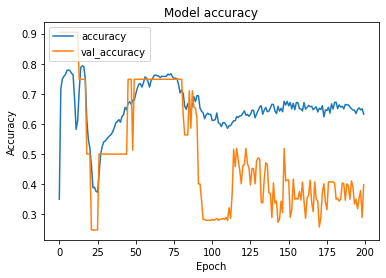

In [51]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

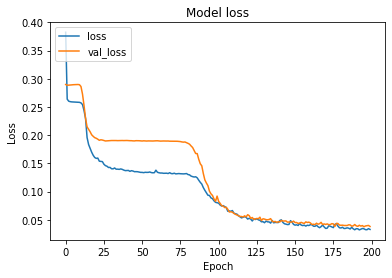

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')

plt.show()

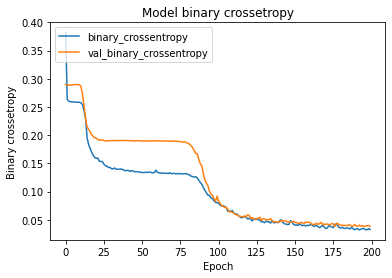

In [53]:
plt.plot(history.history['binary_crossentropy'])
plt.plot(history.history['val_binary_crossentropy'])
plt.title('Model binary crossetropy')
plt.ylabel('Binary crossetropy')
plt.xlabel('Epoch')
plt.legend(['binary_crossentropy', 'val_binary_crossentropy'], loc='upper left')

plt.show()

In [54]:
# predict new notes
prediction = model.predict(inputs_list, verbose=0)
# round prediction to 1 or 0
prediction = np.around(prediction)
# retype it to int
prediction = prediction.astype(int)


In [57]:
bpm = 120
create_midi(bpm, prediction, mid.ticks_per_beat)

In [40]:
print(prediction)
print(instruments)

[[0 1 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 0 1 0 0]]
[36, 40, 42, 46, 48, 49]
